# Installing / Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from pandas import to_datetime
from datetime import datetime, date 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  

# grid search sarima hyperparameters
from math import sqrt
import multiprocessing
multiprocessing.set_start_method('spawn', True)
from multiprocessing import cpu_count

from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools

In [2]:
matplotlib.rcParams['figure.figsize'] = (10,5)

# Data Exploration

In [3]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data

,date,Inquiries_NonStat,Inquiries_Stat
0,2017-01-01,7574.0,NaN
1,2017-01-02,13189.0,NaN
2,2017-01-03,24678.0,NaN
3,2017-01-04,23380.0,1.320733
4,2017-01-05,22809.0,1.247026
...,...,...,...
2095,2022-09-27,11598.0,1.178299
2096,2022-09-28,11886.0,1.298347
2097,2022-09-29,11772.0,NaN
2098,2022-09-30,10669.0,NaN


In [4]:
Daily_data.set_index('date', inplace = True)
Daily_data.isna().any()

Inquiries_NonStat    False
Inquiries_Stat        True
dtype: bool

In [5]:
Daily_data.describe()

,Inquiries_NonStat,Inquiries_Stat
count,2100.000000,2094.000000
mean,14234.188571,0.998492
std,5816.090211,0.328633
min,96.000000,0.038536
25%,9733.750000,0.599834
50%,13863.500000,1.145044
75%,19307.000000,1.233318
max,30619.000000,2.227288


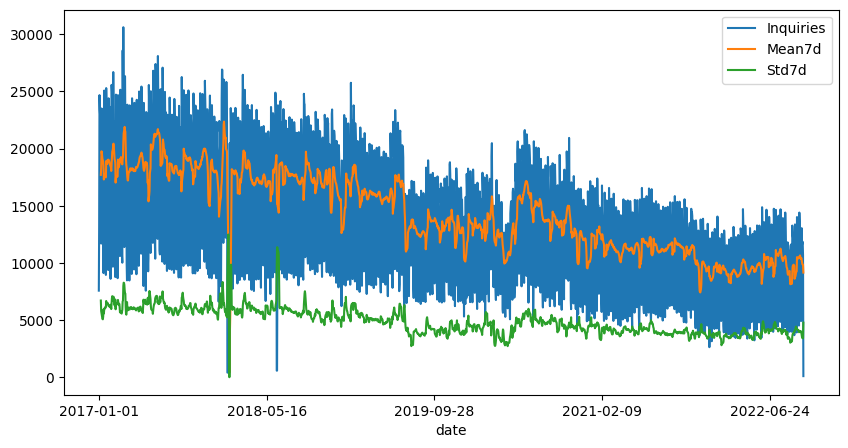

In [6]:
Daily_data['Inquiries_NonStat'].plot(label='Inquiries')
Daily_data.rolling(window=7).mean()['Inquiries_NonStat'].plot(label='Mean7d')
Daily_data.rolling(window=7).std()['Inquiries_NonStat'].plot(label='Std7d')
plt.legend()

In [7]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        if(dfoutput['Test Statistic'] <= dfoutput['Critical Value (%s)'%key] ):
            print('Stationary')
        else:
            print('Non-Stationary')
    print ()
    print (dfoutput)
    print ()
    
adf_test(Daily_data['Inquiries_NonStat'].dropna()) 
# Test Statistics > Critical value (Should be TS <= CV to reject)
# p-value  0.05 (Should be p-value <= significance level to reject)

# Failed to Reject Null hypothesis -- > Non-Stationary data 

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        if(kpss_output['Test Statistic'] > kpss_output['Critical Value (%s)'%key] ):
            print('Non-Stationary')
        else:
            print('Stationary')
    print ()
    print (kpss_output)
    print ()
kpss_test(Daily_data['Inquiries_NonStat'].dropna())
# Test Statistics > Critical value (Should be TS > CV to reject)
# p-value < 0.05 (Should be p-value > significance level to reject)
# Rejected Null hypothesis -- > Non stationary data 

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic                   -1.971946
p-value                           0.299008
#Lags Used                       26.000000
Number of Observations Used    2073.000000
Critical Value (1%)              -3.433508
Critical Value (5%)              -2.862935
Critical Value (10%)             -2.567513
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic           10.122761
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64



C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF test & KPSS test --> Non-Stationary

# SARIMA

### Splitting data into train & test dataset --> 80-20 ratio

In [8]:
Daily_data = Daily_data.loc[:'2022-09-31']
Daily_data = Daily_data.drop(['Inquiries_Stat'],axis=1)

train_df = Daily_data.iloc[:1680]
test_df  = Daily_data.iloc[1679:]
train_df.index = pd.to_datetime(train_df.index)
test_df.index = pd.to_datetime(test_df.index)

### Parameter searching with AIC for SARIMA

In [9]:
from tabulate import tabulate

# Create an empty table
table = []

# Add the column names
table.append(["param", "param_seasonal", "AIC"])

import itertools
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(0,2)
s = range(7,8)


# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            filterwarnings("ignore")
            mod = SARIMAX(train_df,order=param,seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            table.append([param, param_seasonal, results.aic])
        except:
            continue


Optimization terminated successfully.
         Current function value: 11.121072
         Iterations: 1
         Function evaluations: 27
SARIMA(0, 0, 0),(0, 0, 0, 7) - AIC:37368.80145684448
Optimization terminated successfully.
         Current function value: 10.600413
         Iterations: 2
         Function evaluations: 48
SARIMA(0, 0, 0),(0, 0, 1, 7) - AIC:35621.38730791936
Optimization terminated successfully.
         Current function value: 10.288886
         Iterations: 3
         Function evaluations: 134
SARIMA(0, 0, 0),(0, 0, 2, 7) - AIC:34576.65625272243
Optimization terminated successfully.
         Current function value: 9.476555
         Iterations: 1
         Function evaluations: 11
SARIMA(0, 0, 0),(0, 1, 0, 7) - AIC:31843.225139935337
Optimization terminated successfully.
         Current function value: 9.272308
         Iterations: 2
         Function evaluations: 44
SARIMA(0, 0, 0),(0, 1, 1, 7) - AIC:31158.954882791095
Optimization terminated successfully.
      

In [10]:
table1 = tabulate(table)
print(table1)

---------  --------------  ------------------
param      param_seasonal  AIC
(0, 0, 0)  (0, 0, 0, 7)    37368.80145684448
(0, 0, 0)  (0, 0, 1, 7)    35621.38730791936
(0, 0, 0)  (0, 0, 2, 7)    34576.65625272243
(0, 0, 0)  (0, 1, 0, 7)    31843.225139935337
(0, 0, 0)  (0, 1, 1, 7)    31158.954882791095
(0, 0, 0)  (0, 1, 2, 7)    31139.91200715921
(0, 0, 0)  (1, 0, 0, 7)    31983.36617843593
(0, 0, 0)  (1, 0, 1, 7)    31177.757847925503
(0, 0, 0)  (1, 0, 2, 7)    31172.630754922593
(0, 0, 0)  (1, 1, 0, 7)    31513.33419635987
(0, 0, 0)  (1, 1, 1, 7)    31140.11962192978
(0, 0, 0)  (1, 1, 2, 7)    31146.588467991045
(0, 0, 0)  (2, 0, 0, 7)    31618.30888023958
(0, 0, 0)  (2, 0, 1, 7)    31171.825621650198
(0, 0, 0)  (2, 0, 2, 7)    31176.750072037616
(0, 0, 0)  (2, 1, 0, 7)    31371.94617325359
(0, 0, 0)  (2, 1, 1, 7)    31142.275985890046
(0, 0, 0)  (2, 1, 2, 7)    31143.86009867841
(0, 0, 1)  (0, 0, 0, 7)    35615.726080749024
(0, 0, 1)  (0, 0, 1, 7)    34479.933001148274
(0, 0, 1)  (0

### Model with min AIC score

In [11]:
scores_data = np.array(table)
df = pd.DataFrame(table)
df.columns=df.iloc[0] 
df = df.drop(index=0,axis=0)
minAIC = df['AIC'].min()
df[df['AIC'] == minAIC]

,param,param_seasonal,AIC
149,"(1, 0, 2)","(0, 1, 1, 7)",30636.556749


# Predictions
### Lead time = 0 & 7-step ahead

In [12]:
data = Daily_data
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 7
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    #day_list = [1*x for x in range(1,int(len(test))+1)] # days 1,2,3,4 --> [1,2,3,4,..,420]
    for i in day_list:
        # Fit model to training data
        model = SARIMAX(train, order=(1, 0, 2),
                                            seasonal_order = (0, 1, 1, 7)).fit(max_iter = 50,
                                            method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.forecast(steps = steps)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i-steps
        
        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        #rmse_mean = rmse_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)

Optimization terminated successfully.
         Current function value: 9.115325
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.113495
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.111900
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.110023
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.108161
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.110278
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.108547
         Iterations: 4
         Function evaluations: 230
Optimization terminated successful

In [13]:
test_df['7steps_Preds'] = predictions
RMSEsteps_7 = np.mean(rmse_list)
test_df,RMSEsteps_7

(            Inquiries_NonStat  7steps_Preds
 date                                       
 2021-08-07             5879.0   5907.891417
 2021-08-08             4960.0   5268.534182
 2021-08-09            14917.0  14586.796125
 2021-08-10            13359.0  14532.400555
 2021-08-11            13114.0  13788.357438
 ...                       ...           ...
 2022-09-26            13039.0  12273.743560
 2022-09-27            11598.0  12974.701005
 2022-09-28            11886.0  12310.964460
 2022-09-29            11772.0  12131.741424
 2022-09-30            10669.0  10907.428622
 
 [420 rows x 2 columns],
 1107.7814515743478)

### 2 step ahead

In [14]:
data = Daily_data
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 2
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    #day_list = [1*x for x in range(1,int(len(test))+1)] # days 1,2,3,4 --> [1,2,3,4,..,420]
    for i in day_list:
        # Fit model to training data
        model = SARIMAX(train, order=(1, 0, 2),
                                            seasonal_order = (0, 1, 1, 7)).fit(max_iter = 50,
                                            method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.forecast(steps = steps)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i-steps
        
        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        #rmse_mean = rmse_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)

Optimization terminated successfully.
         Current function value: 9.115325
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.114773
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.114321
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.113770
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.113237
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.112687
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.112348
         Iterations: 4
         Function evaluations: 230
Optimization terminated successful

In [15]:
test_df['2steps_Preds'] = predictions
RMSEsteps_2 = np.mean(rmse_list)
test_df,RMSEsteps_2

(            Inquiries_NonStat  7steps_Preds  2steps_Preds
 date                                                     
 2021-08-07             5879.0   5907.891417   5907.891417
 2021-08-08             4960.0   5268.534182   5268.534182
 2021-08-09            14917.0  14586.796125  14465.182692
 2021-08-10            13359.0  14532.400555  14448.971511
 2021-08-11            13114.0  13788.357438  13345.922566
 ...                       ...           ...           ...
 2022-09-26            13039.0  12273.743560  12241.237142
 2022-09-27            11598.0  12974.701005  13316.894969
 2022-09-28            11886.0  12310.964460  12571.122701
 2022-09-29            11772.0  12131.741424  11922.780161
 2022-09-30            10669.0  10907.428622  10723.794790
 
 [420 rows x 3 columns],
 908.6285530775901)

### 3-steps ahead

In [16]:
data = Daily_data
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 3
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    #day_list = [1*x for x in range(1,int(len(test))+1)] # days 1,2,3,4 --> [1,2,3,4,..,420]
    for i in day_list:
        # Fit model to training data
        model = SARIMAX(train, order=(1, 0, 2),
                                            seasonal_order = (0, 1, 1, 7)).fit(max_iter = 50,
                                            method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.forecast(steps = steps)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i-steps
        
        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        #rmse_mean = rmse_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)

Optimization terminated successfully.
         Current function value: 9.115325
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.114509
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.113770
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.112961
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.112348
         Iterations: 4
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 9.111633
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.110833
         Iterations: 4
         Function evaluations: 229
Optimization terminated successful

In [17]:
test_df['3steps_Preds'] = predictions
RMSEsteps_3 = np.mean(rmse_list)
test_df,RMSEsteps_3

(            Inquiries_NonStat  7steps_Preds  2steps_Preds  3steps_Preds
 date                                                                   
 2021-08-07             5879.0   5907.891417   5907.891417   5907.891417
 2021-08-08             4960.0   5268.534182   5268.534182   5268.534182
 2021-08-09            14917.0  14586.796125  14465.182692  14586.796125
 2021-08-10            13359.0  14532.400555  14448.971511  14622.566709
 2021-08-11            13114.0  13788.357438  13345.922566  13830.744373
 ...                       ...           ...           ...           ...
 2022-09-26            13039.0  12273.743560  12241.237142  12241.237142
 2022-09-27            11598.0  12974.701005  13316.894969  12945.525614
 2022-09-28            11886.0  12310.964460  12571.122701  11931.181125
 2022-09-29            11772.0  12131.741424  11922.780161  11939.601437
 2022-09-30            10669.0  10907.428622  10723.794790  10734.979797
 
 [420 rows x 4 columns],
 977.5401734237555)

In [18]:
data = Daily_data
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 4
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    #day_list = [1*x for x in range(1,int(len(test))+1)] # days 1,2,3,4 --> [1,2,3,4,..,420]
    for i in day_list:
        # Fit model to training data
        model = SARIMAX(train, order=(1, 0, 2),
                                            seasonal_order = (0, 1, 1, 7)).fit(max_iter = 50,
                                            method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.forecast(steps = steps)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i-steps
        
        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        #rmse_mean = rmse_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['4steps_Preds'] = predictions
RMSEsteps_4 = np.mean(rmse_list)
test_df,RMSEsteps_4

Optimization terminated successfully.
         Current function value: 9.115325
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.114321
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.113237
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.112348
         Iterations: 4
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 9.111376
         Iterations: 4
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 9.110297
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.109230
         Iterations: 4
         Function evaluations: 230
Optimization terminated successful

(            Inquiries_NonStat  7steps_Preds  2steps_Preds  3steps_Preds  \
 date                                                                      
 2021-08-07             5879.0   5907.891417   5907.891417   5907.891417   
 2021-08-08             4960.0   5268.534182   5268.534182   5268.534182   
 2021-08-09            14917.0  14586.796125  14465.182692  14586.796125   
 2021-08-10            13359.0  14532.400555  14448.971511  14622.566709   
 2021-08-11            13114.0  13788.357438  13345.922566  13830.744373   
 ...                       ...           ...           ...           ...   
 2022-09-26            13039.0  12273.743560  12241.237142  12241.237142   
 2022-09-27            11598.0  12974.701005  13316.894969  12945.525614   
 2022-09-28            11886.0  12310.964460  12571.122701  11931.181125   
 2022-09-29            11772.0  12131.741424  11922.780161  11939.601437   
 2022-09-30            10669.0  10907.428622  10723.794790  10734.979797   
 
          

In [19]:
data = Daily_data
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 5
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    #day_list = [1*x for x in range(1,int(len(test))+1)] # days 1,2,3,4 --> [1,2,3,4,..,420]
    for i in day_list:
        # Fit model to training data
        model = SARIMAX(train, order=(1, 0, 2),
                                            seasonal_order = (0, 1, 1, 7)).fit(max_iter = 50,
                                            method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.forecast(steps = steps)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i-steps
        
        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        #rmse_mean = rmse_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['5steps_Preds'] = predictions
RMSEsteps_5 = np.mean(rmse_list)
test_df,RMSEsteps_5

Optimization terminated successfully.
         Current function value: 9.115325
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.114047
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.112687
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.111633
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.110297
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.108970
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.107647
         Iterations: 4
         Function evaluations: 229
Optimization terminated successful

(            Inquiries_NonStat  7steps_Preds  2steps_Preds  3steps_Preds  \
 date                                                                      
 2021-08-07             5879.0   5907.891417   5907.891417   5907.891417   
 2021-08-08             4960.0   5268.534182   5268.534182   5268.534182   
 2021-08-09            14917.0  14586.796125  14465.182692  14586.796125   
 2021-08-10            13359.0  14532.400555  14448.971511  14622.566709   
 2021-08-11            13114.0  13788.357438  13345.922566  13830.744373   
 ...                       ...           ...           ...           ...   
 2022-09-26            13039.0  12273.743560  12241.237142  12241.237142   
 2022-09-27            11598.0  12974.701005  13316.894969  12945.525614   
 2022-09-28            11886.0  12310.964460  12571.122701  11931.181125   
 2022-09-29            11772.0  12131.741424  11922.780161  11939.601437   
 2022-09-30            10669.0  10907.428622  10723.794790  10734.979797   
 
          

In [20]:
data = Daily_data
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 6
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    #day_list = [1*x for x in range(1,int(len(test))+1)] # days 1,2,3,4 --> [1,2,3,4,..,420]
    for i in day_list:
        # Fit model to training data
        model = SARIMAX(train, order=(1, 0, 2),
                                            seasonal_order = (0, 1, 1, 7)).fit(max_iter = 50,
                                            method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model.forecast(steps = steps)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate MAPE and add to mape_list
        j = i-steps
        
        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        #rmse_mean = rmse_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['6steps_Preds'] = predictions
RMSEsteps_6 = np.mean(rmse_list)
test_df,RMSEsteps_6

Optimization terminated successfully.
         Current function value: 9.115325
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.113770
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 9.112348
         Iterations: 4
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 9.110833
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.109230
         Iterations: 4
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 9.107647
         Iterations: 4
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: 9.110007
         Iterations: 4
         Function evaluations: 231
Optimization terminated successful

(            Inquiries_NonStat  7steps_Preds  2steps_Preds  3steps_Preds  \
 date                                                                      
 2021-08-07             5879.0   5907.891417   5907.891417   5907.891417   
 2021-08-08             4960.0   5268.534182   5268.534182   5268.534182   
 2021-08-09            14917.0  14586.796125  14465.182692  14586.796125   
 2021-08-10            13359.0  14532.400555  14448.971511  14622.566709   
 2021-08-11            13114.0  13788.357438  13345.922566  13830.744373   
 ...                       ...           ...           ...           ...   
 2022-09-26            13039.0  12273.743560  12241.237142  12241.237142   
 2022-09-27            11598.0  12974.701005  13316.894969  12945.525614   
 2022-09-28            11886.0  12310.964460  12571.122701  11931.181125   
 2022-09-29            11772.0  12131.741424  11922.780161  11939.601437   
 2022-09-30            10669.0  10907.428622  10723.794790  10734.979797   
 
          

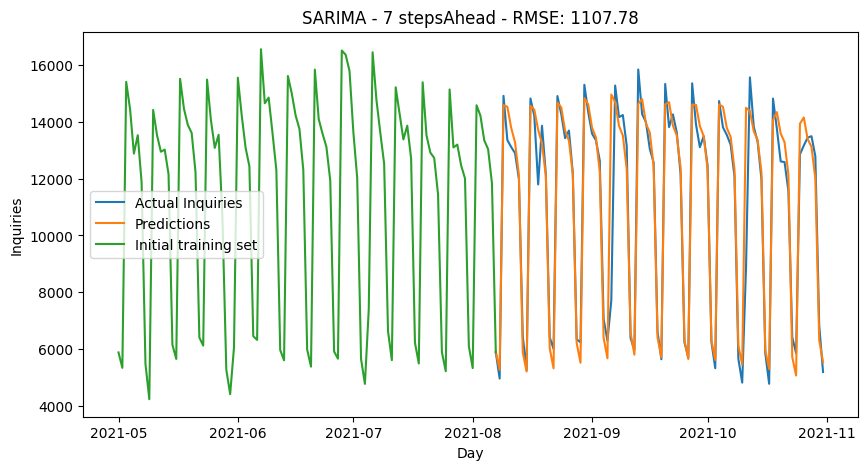

In [21]:
plt.title('SARIMA - 7 stepsAhead - RMSE: 1107.78')
plt.plot(test_df[:'2021-10-31'][['Inquiries_NonStat',	'7steps_Preds']], label = ['Actual Inquiries','Predictions'])
plt.plot(train_df['2021-05-01':], label = 'Initial training set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()



In [22]:
Scores = []
Scores = pd.DataFrame(Scores)
Scores['Steps_Ahead'] = [1,2,3,4,5,6,7]
RMSEsteps_1 = 757.55
Scores['RMSE_SARIMA'] = [RMSEsteps_1,RMSEsteps_2,RMSEsteps_3,RMSEsteps_4,RMSEsteps_5,RMSEsteps_6,RMSEsteps_7]
Scores

,Steps_Ahead,RMSE_SARIMA
0,1,757.550000
1,2,908.628553
2,3,977.540173
3,4,1033.032987
4,5,1031.442874
5,6,1097.426072
6,7,1107.781452


## Exogenous - Holdiays - 7 steps ahead

### Adding holidays to the dataset

In [23]:
import holidays

df=Daily_data
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
# Create a DataFrame of holidays

nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019,2020,2021,2022])
holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
holidays_df = holidays_df.set_index(['date'])

# Join the holidays DataFrame with the original DataFrame
df = df.join(holidays_df, on='date')
df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)
df

,Inquiries_NonStat,holiday
date,,
2017-01-01,7574.0,1.0
2017-01-02,13189.0,1.0
2017-01-03,24678.0,0.0
2017-01-04,23380.0,0.0
2017-01-05,22809.0,0.0
...,...,...
2022-09-26,13039.0,0.0
2022-09-27,11598.0,0.0
2022-09-28,11886.0,0.0


### Model selection using AIC 

In [24]:
# Create an empty table
table = []
data = df
n_test = 1679 #point where data is split into training and test sets
train, test = data[:n_test], data[n_test:]
# Add the column names
table.append(["param", "param_seasonal", "AIC"])

import itertools
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(0,2)
s = range(7,8)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']],
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            table.append([param, param_seasonal, results.aic])
        except:
            continue


Optimization terminated successfully.
         Current function value: 11.110579
         Iterations: 3
         Function evaluations: 127
SARIMA(0, 0, 0),(0, 0, 0, 7) - AIC:37313.32539242624
Optimization terminated successfully.
         Current function value: 10.591231
         Iterations: 3
         Function evaluations: 102
SARIMA(0, 0, 0),(0, 0, 1, 7) - AIC:35571.353810096545
Optimization terminated successfully.
         Current function value: 10.256969
         Iterations: 4
         Function evaluations: 203
SARIMA(0, 0, 0),(0, 0, 2, 7) - AIC:34450.90268449848
Optimization terminated successfully.
         Current function value: 9.351337
         Iterations: 3
         Function evaluations: 145
SARIMA(0, 0, 0),(0, 1, 0, 7) - AIC:31405.78829884871
Optimization terminated successfully.
         Current function value: 9.168986
         Iterations: 2
         Function evaluations: 64
SARIMA(0, 0, 0),(0, 1, 1, 7) - AIC:30795.45342473958
Optimization terminated successfully.
    

In [25]:
scores_data = np.array(table)
df_random = pd.DataFrame(table)
df_random.columns=df_random.iloc[0] 
df_random = df_random.drop(index=0,axis=0)
minAIC = df_random['AIC'].min()
df_random[df_random['AIC'] == minAIC]

,param,param_seasonal,AIC
257,"(2, 0, 2)","(0, 1, 1, 7)",30022.141337


### 7 step ahead Predictions with SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337

In [26]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = df
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 7
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # Fit model to training data
        model2 = SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']], order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)

Optimization terminated successfully.
         Current function value: 8.936896
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.934987
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.933555
         Iterations: 4
         Function evaluations: 420
Optimization terminated successfully.
         Current function value: 8.931704
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.929792
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.928374
         Iterations: 4
         Function evaluations: 419
Optimization terminated successfully.
         Current function value: 8.926544
         Iterations: 4
         Function evaluations: 422
Optimization terminated successful

In [27]:
test_df['7steps_Preds_X_Holidays'] = predictions
RMSEsteps_7_X_Holidays = np.mean(rmse_list)
test_df,RMSEsteps_7_X_Holidays

(            Inquiries_NonStat  7steps_Preds  2steps_Preds  3steps_Preds  \
 date                                                                      
 2021-08-07             5879.0   5907.891417   5907.891417   5907.891417   
 2021-08-08             4960.0   5268.534182   5268.534182   5268.534182   
 2021-08-09            14917.0  14586.796125  14465.182692  14586.796125   
 2021-08-10            13359.0  14532.400555  14448.971511  14622.566709   
 2021-08-11            13114.0  13788.357438  13345.922566  13830.744373   
 ...                       ...           ...           ...           ...   
 2022-09-26            13039.0  12273.743560  12241.237142  12241.237142   
 2022-09-27            11598.0  12974.701005  13316.894969  12945.525614   
 2022-09-28            11886.0  12310.964460  12571.122701  11931.181125   
 2022-09-29            11772.0  12131.741424  11922.780161  11939.601437   
 2022-09-30            10669.0  10907.428622  10723.794790  10734.979797   
 
          

### 2 steps ahead - X(Holiday)

In [28]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = df
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 2
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # Fit model to training data
        model2 = SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']], order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['2steps_Preds_X_Holidays'] = predictions
RMSEsteps_2_X_Holidays = np.mean(rmse_list)
RMSEsteps_2_X_Holidays

Optimization terminated successfully.
         Current function value: 8.936896
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.936353
         Iterations: 4
         Function evaluations: 420
Optimization terminated successfully.
         Current function value: 8.935821
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.935264
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.934727
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.934185
         Iterations: 4
         Function evaluations: 418
Optimization terminated successfully.
         Current function value: 8.933880
         Iterations: 4
         Function evaluations: 420
Optimization terminated successful

790.9059201807099

### 3 steps ahead - X(Holiday)

In [29]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = df
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 3
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # Fit model to training data
        model2 = SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']], order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['3steps_Preds_X_Holidays'] = predictions
RMSEsteps_3_X_Holidays = np.mean(rmse_list)
RMSEsteps_3_X_Holidays

Optimization terminated successfully.
         Current function value: 8.936896
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.936078
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.935264
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.934461
         Iterations: 4
         Function evaluations: 418
Optimization terminated successfully.
         Current function value: 8.933880
         Iterations: 4
         Function evaluations: 420
Optimization terminated successfully.
         Current function value: 8.933294
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.932473
         Iterations: 4
         Function evaluations: 420
Optimization terminated successful

845.4694288092514

### 4 steps ahead - X(Holiday)

In [30]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = df
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 4
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # Fit model to training data
        model2 = SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']], order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['4steps_Preds_X_Holidays'] = predictions
RMSEsteps_4_X_Holidays = np.mean(rmse_list)
RMSEsteps_4_X_Holidays

Optimization terminated successfully.
         Current function value: 8.936896
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.935821
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.934727
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.933880
         Iterations: 4
         Function evaluations: 420
Optimization terminated successfully.
         Current function value: 8.933021
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.931966
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.930894
         Iterations: 4
         Function evaluations: 421
Optimization terminated successful

891.5850581615784

### 5 steps ahead - X(Holiday)

In [31]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = df
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 5
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # Fit model to training data
        model2 = SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']], order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['5steps_Preds_X_Holidays'] = predictions
RMSEsteps_5_X_Holidays = np.mean(rmse_list)
RMSEsteps_5_X_Holidays

Optimization terminated successfully.
         Current function value: 8.936896
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.935541
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.934185
         Iterations: 4
         Function evaluations: 418
Optimization terminated successfully.
         Current function value: 8.933294
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.931966
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.930618
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.929275
         Iterations: 4
         Function evaluations: 422
Optimization terminated successful

911.9254355945725

### 6 steps ahead - X(Holiday)

In [32]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = df
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 6
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # Fit model to training data
        model2 = SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']], order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['6steps_Preds_X_Holidays'] = predictions
RMSEsteps_6_X_Holidays = np.mean(rmse_list)
RMSEsteps_6_X_Holidays

Optimization terminated successfully.
         Current function value: 8.936896
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.935264
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.933880
         Iterations: 4
         Function evaluations: 420
Optimization terminated successfully.
         Current function value: 8.932473
         Iterations: 4
         Function evaluations: 420
Optimization terminated successfully.
         Current function value: 8.930894
         Iterations: 4
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 8.929275
         Iterations: 4
         Function evaluations: 422
Optimization terminated successfully.
         Current function value: 8.928112
         Iterations: 4
         Function evaluations: 419
Optimization terminated successful

908.7317519158102

### Adding scores

In [33]:
RMSEsteps_1_X_Holidays = 642.8313264157767
Scores['RMSE_SARIMA_Holidays'] = [RMSEsteps_1_X_Holidays,RMSEsteps_2_X_Holidays,RMSEsteps_3_X_Holidays,
RMSEsteps_4_X_Holidays,RMSEsteps_5_X_Holidays,RMSEsteps_6_X_Holidays,RMSEsteps_7_X_Holidays]
Scores

,Steps_Ahead,RMSE_SARIMA,RMSE_SARIMA_Holidays
0,1,757.550000,642.831326
1,2,908.628553,790.905920
2,3,977.540173,845.469429
3,4,1033.032987,891.585058
4,5,1031.442874,911.925436
5,6,1097.426072,908.731752
6,7,1107.781452,926.378218


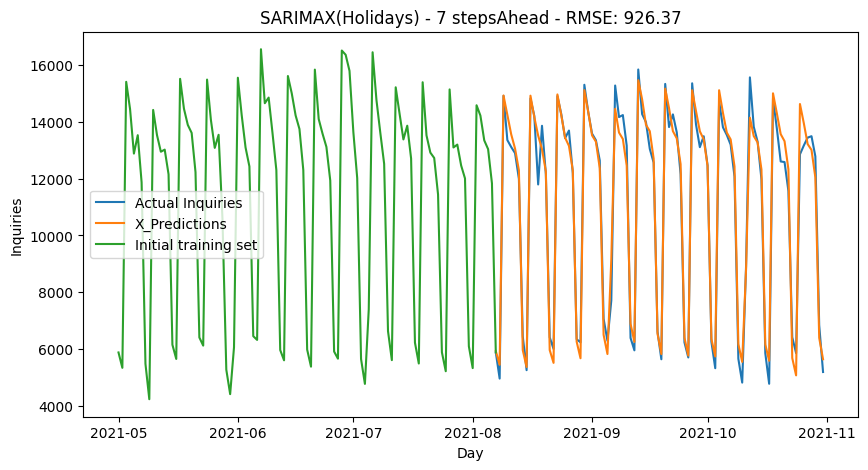

In [34]:
plt.title('SARIMAX(Holidays) - 7 stepsAhead - RMSE: 926.37')
plt.plot(test_df[:'2021-10-31'][['Inquiries_NonStat', '7steps_Preds_X_Holidays']], label = ['Actual Inquiries','X_Predictions'])
plt.plot(train_df['2021-05-01':], label = 'Initial training set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()   

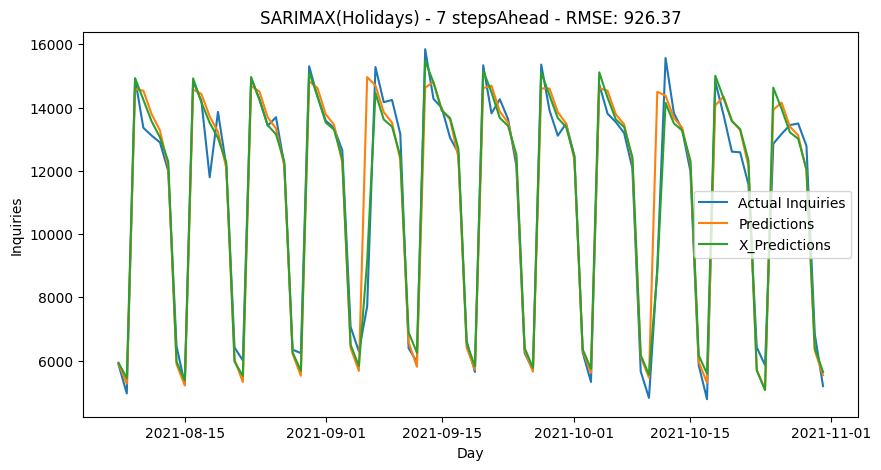

In [35]:
plt.title('SARIMAX(Holidays) - 7 stepsAhead - RMSE: 926.37')
plt.plot(test_df[:'2021-10-31'][['Inquiries_NonStat', '7steps_Preds','7steps_Preds_X_Holidays']], label = ['Actual Inquiries','Predictions','X_Predictions'])
#plt.plot(train_df['2021-05-01':], label = 'Initial training set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()

## Exogenous - Holdiays + Weekends + Weekdays - 7 steps ahead

### Adding weekdays to dataset

In [36]:
df

,Inquiries_NonStat,holiday
date,,
2017-01-01,7574.0,1.0
2017-01-02,13189.0,1.0
2017-01-03,24678.0,0.0
2017-01-04,23380.0,0.0
2017-01-05,22809.0,0.0
...,...,...
2022-09-26,13039.0,0.0
2022-09-27,11598.0,0.0
2022-09-28,11886.0,0.0


In [37]:
exog_df = df.reset_index()
exog_df['Month'] = pd.to_datetime(exog_df['date']).dt.month.astype('int32')
exog_df['Weekday'] = pd.to_datetime(exog_df['date']).dt.day_name()

exog_df['Weekend'] = 0
exog_df.loc[(exog_df['Weekday'] == 'Saturday'),'Weekend'] = 1
exog_df.loc[(exog_df['Weekday'] == 'Sunday'),'Weekend'] = 1

from sklearn import preprocessing
# transform data
le = preprocessing.LabelEncoder()
le.fit(exog_df['Weekday'])
#LabelEncoder()
list(le.classes_)
exog_df['Weekday_encoded'] = le.transform(exog_df['Weekday'])
exog_df = exog_df.set_index('date')
print(exog_df)

            Inquiries_NonStat  holiday  Month    Weekday  Weekend  \
date                                                                
2017-01-01             7574.0      1.0      1     Sunday        1   
2017-01-02            13189.0      1.0      1     Monday        0   
2017-01-03            24678.0      0.0      1    Tuesday        0   
2017-01-04            23380.0      0.0      1  Wednesday        0   
2017-01-05            22809.0      0.0      1   Thursday        0   
...                       ...      ...    ...        ...      ...   
2022-09-26            13039.0      0.0      9     Monday        0   
2022-09-27            11598.0      0.0      9    Tuesday        0   
2022-09-28            11886.0      0.0      9  Wednesday        0   
2022-09-29            11772.0      0.0      9   Thursday        0   
2022-09-30            10669.0      0.0      9     Friday        0   

            Weekday_encoded  
date                         
2017-01-01                3  
2017-01-02  

In [38]:
exog_df

,Inquiries_NonStat,holiday,Month,Weekday,Weekend,Weekday_encoded
date,,,,,,
2017-01-01,7574.0,1.0,1,Sunday,1,3
2017-01-02,13189.0,1.0,1,Monday,0,1
2017-01-03,24678.0,0.0,1,Tuesday,0,5
2017-01-04,23380.0,0.0,1,Wednesday,0,6
2017-01-05,22809.0,0.0,1,Thursday,0,4
...,...,...,...,...,...,...
2022-09-26,13039.0,0.0,9,Monday,0,1
2022-09-27,11598.0,0.0,9,Tuesday,0,5
2022-09-28,11886.0,0.0,9,Wednesday,0,6


### Model selection with AIC comparison for exogenous variables (Holidays + weekdays + is_weekend)

In [39]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = exog_df
n_test = 1679 #point where data is split into training and test sets
train_ex, test_ex = exog_df[:n_test], exog_df[n_test:]

def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 7
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        endog = train[['Inquiries_NonStat']]
        exog = train.drop(['Inquiries_NonStat','Weekday'],axis=1)
        
        exog_forecast = test.drop(['Inquiries_NonStat','Weekday'],axis=1)[i-steps:i]
        # Fit model to training data
        model2 = SARIMAX(endog, exog, order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)

Optimization terminated successfully.
         Current function value: 8.931970
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.930114
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.928675
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.926824
         Iterations: 4
         Function evaluations: 546
Optimization terminated successfully.
         Current function value: 8.924911
         Iterations: 4
         Function evaluations: 546
Optimization terminated successfully.
         Current function value: 8.923423
         Iterations: 4
         Function evaluations: 545
Optimization terminated successfully.
         Current function value: 8.921595
         Iterations: 4
         Function evaluations: 546
Optimization terminated successful

In [40]:
test_df['7steps_Preds_X_All'] = predictions
RMSEsteps_7_X_All = np.mean(rmse_list)
test_df,RMSEsteps_7_X_All

(            Inquiries_NonStat  7steps_Preds  2steps_Preds  3steps_Preds  \
 date                                                                      
 2021-08-07             5879.0   5907.891417   5907.891417   5907.891417   
 2021-08-08             4960.0   5268.534182   5268.534182   5268.534182   
 2021-08-09            14917.0  14586.796125  14465.182692  14586.796125   
 2021-08-10            13359.0  14532.400555  14448.971511  14622.566709   
 2021-08-11            13114.0  13788.357438  13345.922566  13830.744373   
 ...                       ...           ...           ...           ...   
 2022-09-26            13039.0  12273.743560  12241.237142  12241.237142   
 2022-09-27            11598.0  12974.701005  13316.894969  12945.525614   
 2022-09-28            11886.0  12310.964460  12571.122701  11931.181125   
 2022-09-29            11772.0  12131.741424  11922.780161  11939.601437   
 2022-09-30            10669.0  10907.428622  10723.794790  10734.979797   
 
          

### 2-steps ahead - X_all

In [41]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = exog_df
n_test = 1679 #point where data is split into training and test sets
train_ex, test_ex = exog_df[:n_test], exog_df[n_test:]

def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 2
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        endog = train[['Inquiries_NonStat']]
        exog = train.drop(['Inquiries_NonStat','Weekday'],axis=1)
        
        exog_forecast = test.drop(['Inquiries_NonStat','Weekday'],axis=1)[i-steps:i]
        # Fit model to training data
        model2 = SARIMAX(endog, exog, order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['2steps_Preds_X_All'] = predictions
RMSEsteps_2_X_All = np.mean(rmse_list)
RMSEsteps_2_X_All

Optimization terminated successfully.
         Current function value: 8.931970
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.931427
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.930950
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.930394
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929855
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929315
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929000
         Iterations: 4
         Function evaluations: 546
Optimization terminated successful

797.1545819257123

### 3-steps ahead - X_all

In [42]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = exog_df
n_test = 1679 #point where data is split into training and test sets
train_ex, test_ex = exog_df[:n_test], exog_df[n_test:]

def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 3
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        endog = train[['Inquiries_NonStat']]
        exog = train.drop(['Inquiries_NonStat','Weekday'],axis=1)
        
        exog_forecast = test.drop(['Inquiries_NonStat','Weekday'],axis=1)[i-steps:i]
        # Fit model to training data
        model2 = SARIMAX(endog, exog, order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['3steps_Preds_X_All'] = predictions
RMSEsteps_3_X_All = np.mean(rmse_list)
RMSEsteps_3_X_All

Optimization terminated successfully.
         Current function value: 8.931970
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.931155
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.930394
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929591
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929000
         Iterations: 4
         Function evaluations: 546
Optimization terminated successfully.
         Current function value: 8.928416
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.927593
         Iterations: 4
         Function evaluations: 547
Optimization terminated successful

849.1903336729258

### 4-steps ahead - X_all

In [43]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = exog_df
n_test = 1679 #point where data is split into training and test sets
train_ex, test_ex = exog_df[:n_test], exog_df[n_test:]

def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 4
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        endog = train[['Inquiries_NonStat']]
        exog = train.drop(['Inquiries_NonStat','Weekday'],axis=1)
        
        exog_forecast = test.drop(['Inquiries_NonStat','Weekday'],axis=1)[i-steps:i]
        # Fit model to training data
        model2 = SARIMAX(endog, exog, order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['4steps_Preds_X_All'] = predictions
RMSEsteps_4_X_All = np.mean(rmse_list)
RMSEsteps_4_X_All

Optimization terminated successfully.
         Current function value: 8.931970
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.930950
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929855
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929000
         Iterations: 4
         Function evaluations: 546
Optimization terminated successfully.
         Current function value: 8.928143
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.927089
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.926016
         Iterations: 4
         Function evaluations: 546
Optimization terminated successful

899.6945780101106

### 5-steps ahead - X_all

In [44]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = exog_df
n_test = 1679 #point where data is split into training and test sets
train_ex, test_ex = exog_df[:n_test], exog_df[n_test:]

def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 5
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        endog = train[['Inquiries_NonStat']]
        exog = train.drop(['Inquiries_NonStat','Weekday'],axis=1)
        
        exog_forecast = test.drop(['Inquiries_NonStat','Weekday'],axis=1)[i-steps:i]
        # Fit model to training data
        model2 = SARIMAX(endog, exog, order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['5steps_Preds_X_All'] = predictions
RMSEsteps_5_X_All = np.mean(rmse_list)
RMSEsteps_5_X_All

Optimization terminated successfully.
         Current function value: 8.931970
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.930671
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929315
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.928416
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.927089
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.925739
         Iterations: 4
         Function evaluations: 546
Optimization terminated successfully.
         Current function value: 8.924397
         Iterations: 4
         Function evaluations: 546
Optimization terminated successful

916.469185735745

### 6-steps ahead - X_all

In [45]:
# SARIMAX((2, 0, 2)	(0, 1, 1, 7)) AIC --> 30022.141337
data = exog_df
n_test = 1679 #point where data is split into training and test sets
train_ex, test_ex = exog_df[:n_test], exog_df[n_test:]

def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    steps = 6
    
    day_list = [steps*x for x in range(1,int(len(test)/steps+1))] # [7,14,28,..,420]
    for i in day_list:
        endog = train[['Inquiries_NonStat']]
        exog = train.drop(['Inquiries_NonStat','Weekday'],axis=1)
        
        exog_forecast = test.drop(['Inquiries_NonStat','Weekday'],axis=1)[i-steps:i]
        # Fit model to training data
        model2 = SARIMAX(endog, exog, order=(2, 0, 2), 
                                seasonal_order = (2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = steps, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-steps
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)
test_df['6steps_Preds_X_All'] = predictions
RMSEsteps_6_X_All = np.mean(rmse_list)
RMSEsteps_6_X_All

Optimization terminated successfully.
         Current function value: 8.931970
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.930394
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.929000
         Iterations: 4
         Function evaluations: 546
Optimization terminated successfully.
         Current function value: 8.927593
         Iterations: 4
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 8.926016
         Iterations: 4
         Function evaluations: 546
Optimization terminated successfully.
         Current function value: 8.924397
         Iterations: 4
         Function evaluations: 546
Optimization terminated successfully.
         Current function value: 8.923161
         Iterations: 4
         Function evaluations: 545
Optimization terminated successful

915.3558157110647

### Adding scores

In [46]:
RMSEsteps_1_X_All = 682.4042353672273
Scores['RMSE_SARIMA_X_All'] = [RMSEsteps_1_X_All,RMSEsteps_2_X_All,RMSEsteps_3_X_All,
RMSEsteps_4_X_All,RMSEsteps_5_X_All,RMSEsteps_6_X_All,RMSEsteps_7_X_All]
Scores

,Steps_Ahead,RMSE_SARIMA,RMSE_SARIMA_Holidays,RMSE_SARIMA_X_All
0,1,757.550000,642.831326,682.404235
1,2,908.628553,790.905920,797.154582
2,3,977.540173,845.469429,849.190334
3,4,1033.032987,891.585058,899.694578
4,5,1031.442874,911.925436,916.469186
5,6,1097.426072,908.731752,915.355816
6,7,1107.781452,926.378218,935.672764


In [47]:
test_df

,Inquiries_NonStat,7steps_Preds,2steps_Preds,3steps_Preds,4steps_Preds,5steps_Preds,6steps_Preds,7steps_Preds_X_Holidays,2steps_Preds_X_Holidays,3steps_Preds_X_Holidays,4steps_Preds_X_Holidays,5steps_Preds_X_Holidays,6steps_Preds_X_Holidays,7steps_Preds_X_All,2steps_Preds_X_All,3steps_Preds_X_All,4steps_Preds_X_All,5steps_Preds_X_All,6steps_Preds_X_All
date,,,,,,,,,,,,,,,,,,,
2021-08-07,5879.0,5907.891417,5907.891417,5907.891417,5907.891417,5907.891417,5907.891417,5929.895276,5929.895276,5929.895276,5929.895276,5929.895276,5929.895276,5914.960802,5914.960802,5914.960802,5914.960802,5914.960802,5914.960802
2021-08-08,4960.0,5268.534182,5268.534182,5268.534182,5268.534182,5268.534182,5268.534182,5444.544541,5444.544541,5444.544541,5444.544541,5444.544541,5444.544541,5429.847138,5429.847138,5429.847138,5429.847138,5429.847138,5429.847138
2021-08-09,14917.0,14586.796125,14465.182692,14586.796125,14586.796125,14586.796125,14586.796125,14929.262778,14697.647733,14929.262778,14929.262778,14929.262778,14929.262778,14862.270182,14645.289427,14862.270182,14862.270182,14862.270182,14862.270182
2021-08-10,13359.0,14532.400555,14448.971511,14622.566709,14532.400555,14532.400555,14532.400555,14246.761731,14096.171987,14199.475264,14246.761731,14246.761731,14246.761731,14176.222532,14036.245131,14160.206610,14176.222532,14176.222532,14176.222532
2021-08-11,13114.0,13788.357438,13345.922566,13830.744373,13345.922566,13788.357438,13788.357438,13560.972827,13071.379928,13466.867758,13071.379928,13560.972827,13560.972827,13485.286769,13047.752674,13413.562949,13047.752674,13485.286769,13485.286769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,13039.0,12273.743560,12241.237142,12241.237142,12340.730966,12495.819582,12241.237142,12891.947999,12872.558682,12872.558682,12966.089649,13207.332791,12872.558682,12828.621701,12816.608013,12816.608013,12897.064094,13151.479974,12816.608013
2022-09-27,11598.0,12974.701005,13316.894969,12945.525614,13316.894969,13114.696229,12945.525614,12854.956598,12961.600324,12833.959473,12961.600324,13039.893224,12833.959473,12803.801709,12946.254457,12790.760024,12946.254457,12997.155641,12790.760024
2022-09-28,11886.0,12310.964460,12571.122701,11931.181125,12571.122701,12436.706995,12284.758401,12205.395793,12363.742544,11729.119575,12363.742544,12411.764189,12188.893971,12174.924534,12357.400618,11746.982675,12357.400618,12388.559661,12164.692030


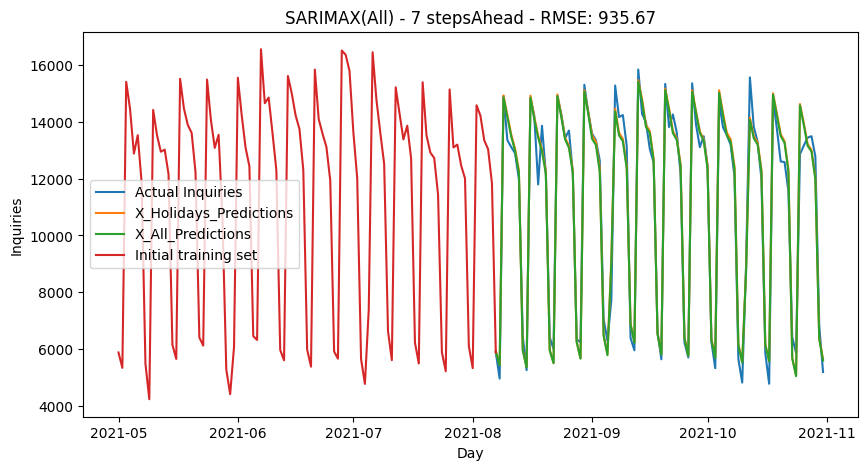

In [48]:
plt.title('SARIMAX(All) - 7 stepsAhead - RMSE: 935.67')
plt.plot(test_df[:'2021-10-31'][['Inquiries_NonStat', '7steps_Preds_X_Holidays','7steps_Preds_X_All']], label = ['Actual Inquiries','X_Holidays_Predictions','X_All_Predictions'])
#plt.plot(test_df[:'2021-10-31'])
plt.plot(train_df['2021-05-01':], label = 'Initial training set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()

# Saving Scores

In [49]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/04-notebooks/03-modeling/'
Scores.to_csv(path+'SARIMA_Scores.csv', sep=',')

In [50]:
Scores

,Steps_Ahead,RMSE_SARIMA,RMSE_SARIMA_Holidays,RMSE_SARIMA_X_All
0,1,757.550000,642.831326,682.404235
1,2,908.628553,790.905920,797.154582
2,3,977.540173,845.469429,849.190334
3,4,1033.032987,891.585058,899.694578
4,5,1031.442874,911.925436,916.469186
5,6,1097.426072,908.731752,915.355816
6,7,1107.781452,926.378218,935.672764


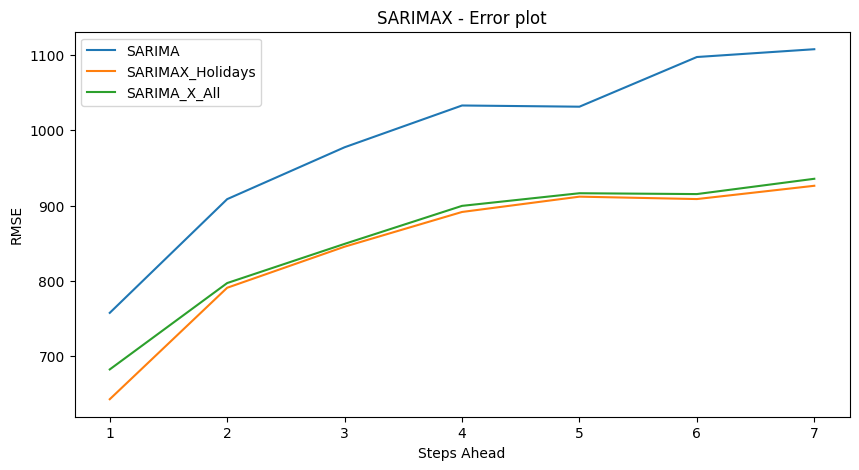

In [68]:
plt.title('SARIMAX - Error plot')

plt.plot(Scores['Steps_Ahead'],Scores[['RMSE_SARIMA',	'RMSE_SARIMA_Holidays',	'RMSE_SARIMA_X_All']],label=['SARIMA',	'SARIMAX_Holidays',	'SARIMA_X_All'])
#plt.set_color_cycle(['c', 'm', 'y', 'k'])
plt.xlabel('Steps Ahead')
plt.ylabel('RMSE')
plt.legend()

In [91]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=Scores['Steps_Ahead'],
        y=Scores['RMSE_SARIMA'],
        #,	'RMSE_SARIMA_Holidays',	'RMSE_SARIMA_X_All']],
        name='SARIMA',#	'SARIMAX_Holidays',	'SARIMA_X_All'],
        mode='lines+markers', 
        #mode = 'lines'
        marker= dict(size=5,
                     symbol = 'diamond',
                     #color ='RGB(251, 177, 36)',
                     line_width = 1
                   ),
        line = dict(color='purple', width=2)
    ))
fig.add_trace(
    go.Scatter(
        x=Scores['Steps_Ahead'],
        y=Scores['RMSE_SARIMA_Holidays'],
        #,	'RMSE_SARIMA_Holidays',	'RMSE_SARIMA_X_All']],
        name='SARIMAX_Holidays',#	'SARIMAX_Holidays',	'SARIMA_X_All'],
        mode='lines+markers', 
#         mode = 'lines'
        marker= dict(size=5,
                     symbol = 'diamond',
                     #color ='RGB(251, 177, 36)',
                     line_width = 1
                   ),
        line = dict(color='forestgreen', width=2)
    ))
fig.add_trace(
    go.Scatter(
        x=Scores['Steps_Ahead'],
        y=Scores['RMSE_SARIMA_X_All'],
        #,	'RMSE_SARIMA_Holidays',	'RMSE_SARIMA_X_All']],
        name='SARIMA_X_All',#	'SARIMAX_Holidays',	'SARIMA_X_All'],
        mode='lines+markers', 
#         mode = 'lines'
        marker= dict(size=5,
                     symbol = 'diamond',
                     #color ='RGB(251, 177, 36)',
                     line_width = 1
                   ),
        line = dict(color='firebrick', width=2)
    ))
fig.update_traces(texttemplate='%{text:.2s}')
#fig.update_layout(legend_title_text='Parameters',title_text='SARIMAX - RMSE for different steps ahead')
# strip down the rest of the plot
fig.update_layout(
    showlegend=True,
    plot_bgcolor="rgb(240,240,240)",
    margin=dict(t=50,l=10,b=10,r=10),
    title_text='SARIMAX - RMSE graph for different steps ahead',
    title_font_family="Times New Roman",
    title_font_size = 25,
    title_font_color="darkblue",
    title_x=0.5,
    xaxis=dict(
        title='Steps Ahead',tickfont_size=12,
        tickangle = 0,
        showgrid = True,
        zeroline = True,
        showline = True,
        showticklabels = True,
        dtick=1
    ),
    yaxis=dict(
        title='Error',
        titlefont_size=12,
        tickangle = 0,
        showticklabels = True,
        tickfont_size=12
    ),
    legend=dict(
        x=0.01,
        y=0.99,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    bargap=0.15
)
fig.show()